In [1]:
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import spacy
from numpy import zeros, column_stack
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_lg")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [2]:
df = pandas.read_csv("troon_instagram_post_beer_attributes.csv")
df

,id,attribute,count
0,203,coffee,1
1,203,conditioned,1
2,203,imperial,1
3,203,imperial milk stout,1
4,203,milk,1
...,...,...,...
1283,302,sour ale,1
1284,302,orange zest,1
1285,316,hoppy,1
1286,316,ale,1


In [3]:
vectors = []
attributes = sorted(set(df["attribute"]))

for attribute in attributes:
    tokens = attribute.lower().split(" ")
    if len(tokens) == 1:
        vectors.append(nlp(tokens[0]).vector)
    else:
        v = nlp(tokens[0]).vector
        for t in tokens[1:]:
            if t != "&":
                v = v + nlp(t).vector
        vectors.append(v)

In [4]:
len(vectors)

253

---

In [5]:
# TODO: Come back to this.  The maximum silhouette score is terrible and agglomerative clustering didn't really help.
# cluster_sizes = []
# silhouettes = []

# for i in range(3, len(vectors) // 2):
#     cluster_sizes.append(i)
#     kmeans = KMeans(n_clusters=i, random_state=1024).fit(vectors)
#     silhouettes.append(silhouette_score(vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
# g = sns.lineplot(x=cluster_sizes, y=silhouettes)

In [6]:
# cluster_sizes[silhouettes.index(max(silhouettes))]

In [7]:
# kmeans = KMeans(n_clusters=cluster_sizes[silhouettes.index(max(silhouettes))], random_state=1024).fit(vectors)

# tsne = TSNE(n_components=2, random_state=1024, metric="cosine")
# reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(vectors)))
# ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
# plt.show()

In [8]:
# sorted(list(zip(attributes, kmeans.labels_)), key=lambda x : x[1])

---

In [9]:
attribute_vectors = dict(zip(attributes, vectors))
beer_ids = sorted(set(df["id"]))
beer_vectors = []

for beer_id in beer_ids:
    vector = zeros(300)
    for (i, row) in df[df["id"] == beer_id].iterrows():
        for j in range(0, row["count"]):
            vector = vector + attribute_vectors[row["attribute"]]
    beer_vectors.append(vector)

Text(0, 0.5, 'Silhouette Score')

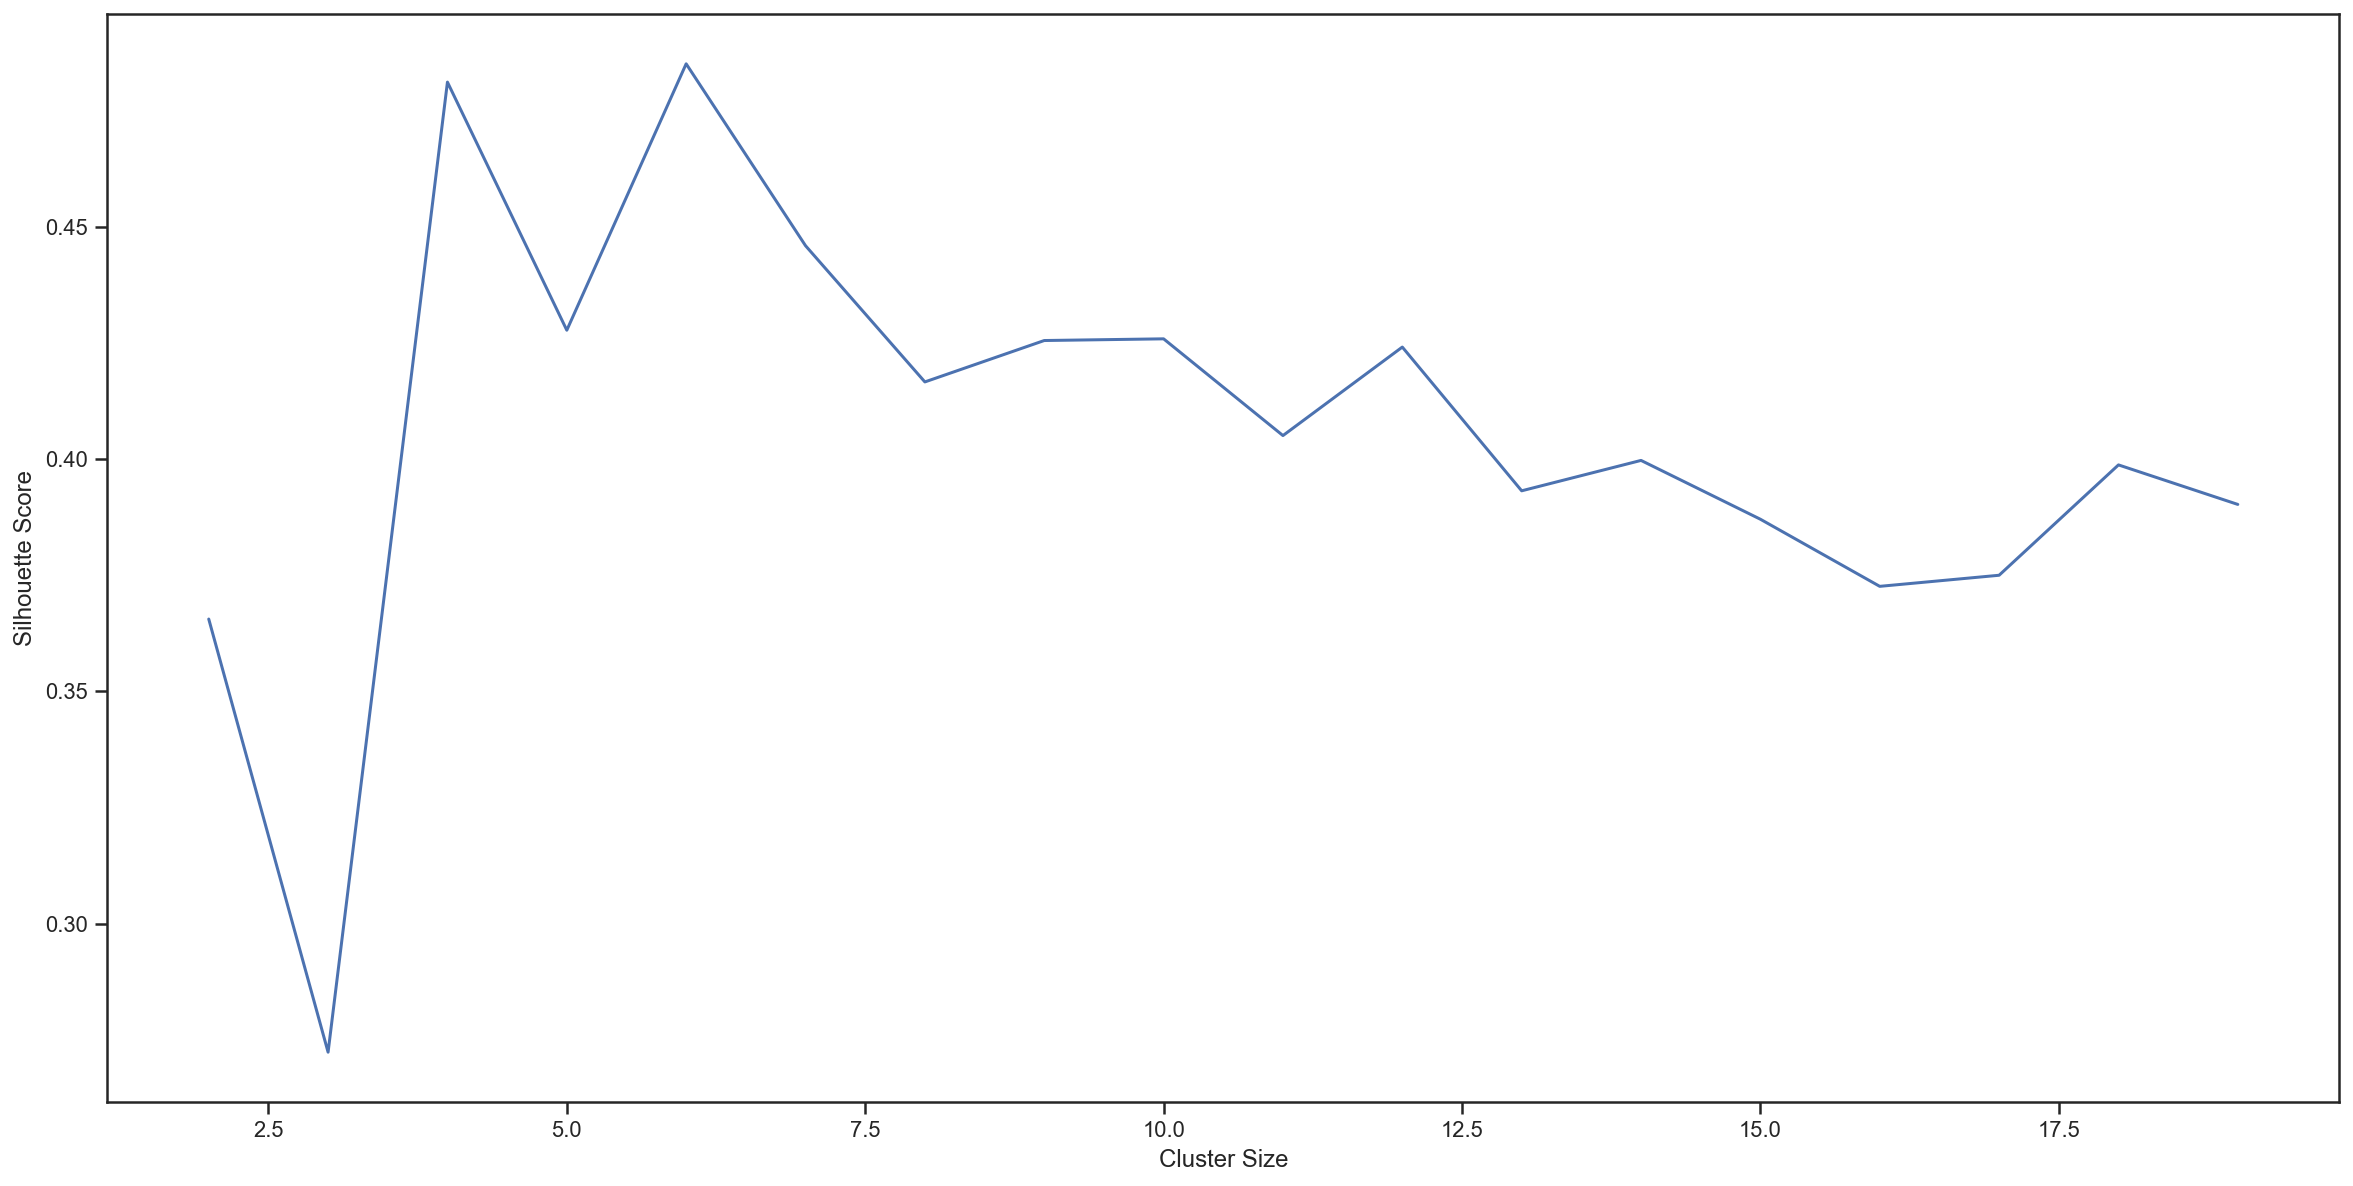

In [10]:
cluster_sizes = []
silhouettes = []

for i in range(2, 20):
    cluster_sizes.append(i)
    kmeans = KMeans(n_clusters=i, random_state=1024).fit(beer_vectors)
    silhouettes.append(silhouette_score(beer_vectors, kmeans.labels_, random_state=1024, metric="cosine"))
                       
g = sns.lineplot(x=cluster_sizes, y=silhouettes)
g.set_xlabel("Cluster Size")
g.set_ylabel("Silhouette Score")

In [16]:
best_cluster_size = cluster_sizes[silhouettes.index(max(silhouettes))]
best_cluster_size = 4
#best_cluster_size

/usr/local/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


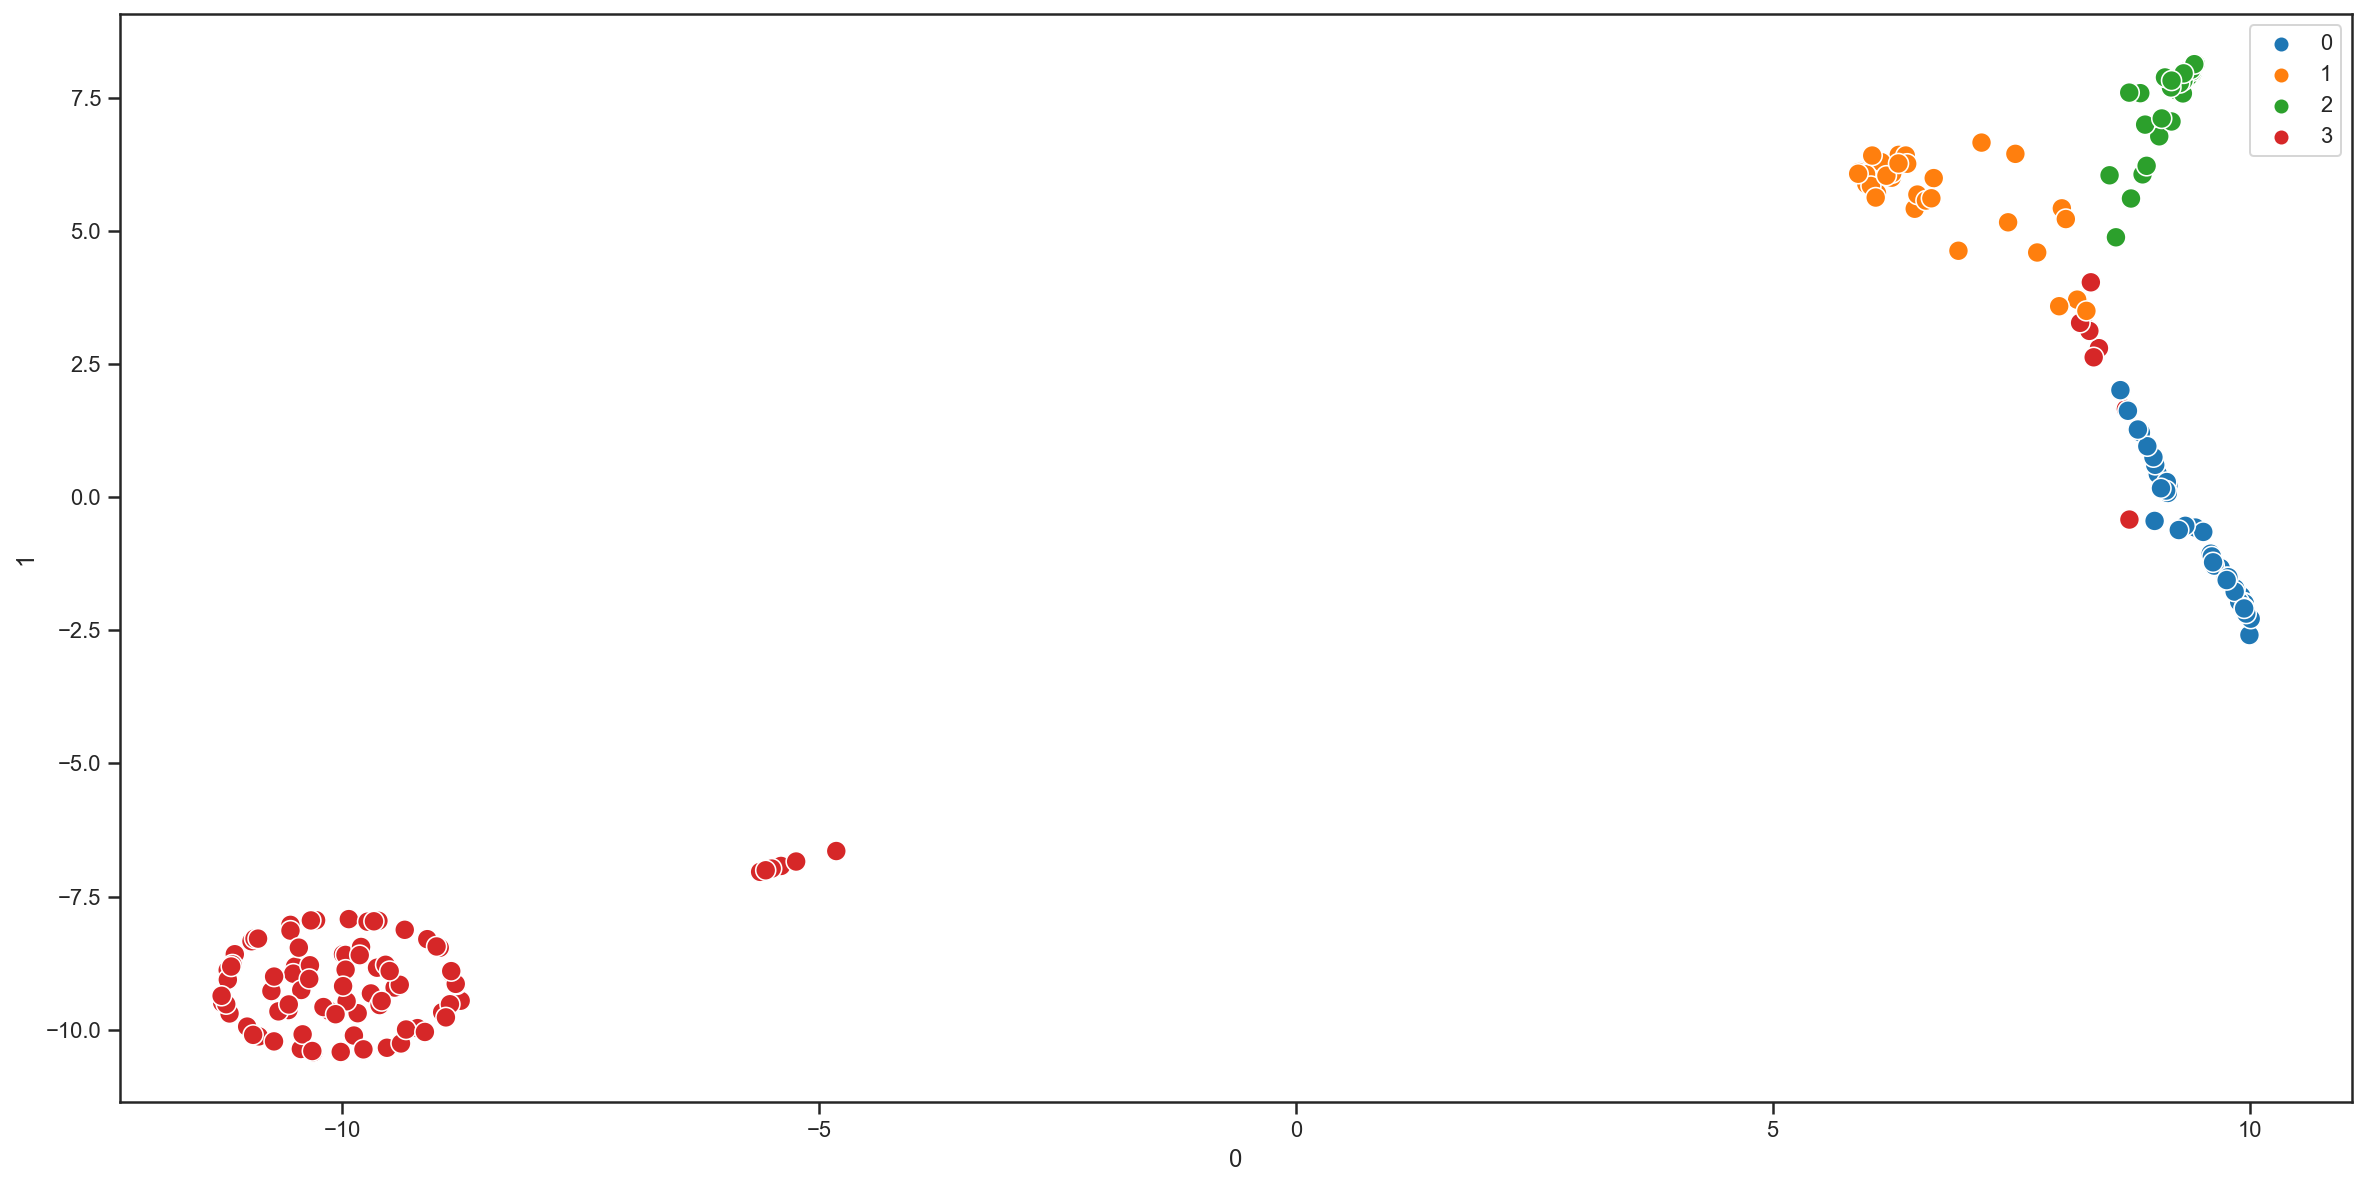

In [17]:
kmeans = KMeans(n_clusters=best_cluster_size, random_state=1024).fit(beer_vectors)

tsne = TSNE(n_components=2, random_state=1024, metric="cosine", learning_rate=100, square_distances=True)
reduced = pandas.DataFrame(tsne.fit_transform(kmeans.transform(beer_vectors)))
ax = sns.scatterplot(x=reduced[0], y=reduced[1], hue=kmeans.labels_, s=100, palette="tab10")
plt.show()

In [18]:
cluster_attributes = {l : [] for l in set(kmeans.labels_)}
reduced["id"] = beer_ids
reduced["cluster_id"] = kmeans.labels_

for (i, row) in reduced.iterrows():
    attributes = list(df[df["id"] == row["id"]]["attribute"])
    cluster_attributes[row["cluster_id"]] += attributes

appearing_in_all = None
for cluster_id in cluster_attributes:
    if appearing_in_all is None:
        appearing_in_all = set(cluster_attributes[cluster_id])
    else:
        appearing_in_all = appearing_in_all.intersection(set(cluster_attributes[cluster_id]))
        
print(appearing_in_all)
    
{c : sorted(Counter([a for a in cluster_attributes[c] if a not in appearing_in_all]).items(), 
            key=lambda x : x[1], reverse=True) for c in cluster_attributes}

{'ale', 'conditioned', 'hoppy', 'lactose', 'refermented'}


{0: [('hopped', 20),
  ('ipa', 9),
  ('lupulin', 6),
  ('powder', 6),
  ('session', 5),
  ('@rojosroastery', 4),
  ('simcoe', 4),
  ('mosaic', 4),
  ('citra', 4),
  ('american', 3),
  ('keller', 3),
  ('coffee', 3),
  ('enigma', 3),
  ('galaxy', 3),
  ('oats', 2),
  ('azacca', 2),
  ('collaboration', 2),
  ('session ipa', 2),
  ('vic secret', 2),
  ('american varietals', 2),
  ('dry hopped', 2),
  ('amarillo', 2),
  ('wheat', 2),
  ('pineapple', 2),
  ('triple', 2),
  ('triple ipa', 2),
  ('dipa', 2),
  ('smoothie', 2),
  ('medusa', 2),
  ('lager', 2),
  ('@thereferendbierblendery', 1),
  ('american blonde', 1),
  ('blonde', 1),
  ('motueka', 1),
  ('grist', 1),
  ('organic', 1),
  ('el dorado', 1),
  ('yeast', 1),
  ('carrion', 1),
  ('keller pils', 1),
  ('pils', 1),
  ('southern hemisphere', 1),
  ('fresh', 1),
  ('cacao', 1),
  ('cacao nibs', 1),
  ('ochochoque', 1),
  ('pastrywine', 1),
  ('quilla', 1),
  ('kölsch', 1),
  ('palo santo wood', 1),
  ('dryhopped', 1),
  ('hoped', 1),

In [19]:
cluster_names = {0 : "IPAs", 1 : "Sours", 2 : "Stouts", 3 : "Hoppy Ales"}

In [20]:
reduced["cluster_name"] = reduced["cluster_id"].apply(lambda x : cluster_names[x])

In [21]:
reduced["attributes"] = reduced["id"].apply(lambda x : ", ".join(sorted(df[df["id"] == x]["attribute"])))
reduced

,0,1,id,cluster_id,cluster_name,attributes
0,-10.492240,-8.814530,0,3,Hoppy Ales,"ale, hoppy, hoppy ale"
1,-10.510424,-8.946256,1,3,Hoppy Ales,"ale, hoppy, hoppy ale"
2,-10.301213,-10.420621,2,3,Hoppy Ales,"ale, hoppy, hoppy ale"
3,-5.626436,-7.039871,3,3,Hoppy Ales,"ale, honey, hoppy, hoppy ale"
4,-5.396924,-6.924539,6,3,Hoppy Ales,"ale, hoppy, hoppy ale, lactose, peach, referme..."
...,...,...,...,...,...,...
212,-10.452417,-8.458432,311,3,Hoppy Ales,"ale, hoppy, hoppy ale"
213,8.289544,3.495160,312,1,Sours,"conditioned, guava, gummies, lactose, refermen..."
214,-8.854562,-8.899195,313,3,Hoppy Ales,"ale, hoppy, hoppy ale"
215,-9.008388,-8.436211,314,3,Hoppy Ales,"ale, hoppy, hoppy ale"


In [22]:
reduced.to_csv("troon_TSNE_kmeans_clusters.csv", index=False)